In [1]:
top_directory = '/Users/iaincarmichael/Dropbox/Research/law/law-net/'

from __future__ import division

import os
import sys
import time
from math import *
import copy
import cPickle as pickle

# data
import numpy as np
import pandas as pd

# viz
import matplotlib.pyplot as plt


# graph
import igraph as ig

# our code
sys.path.append(top_directory + 'code/')
from load_data import load_and_clean_graph, case_info
from pipeline.download_data import download_bulk_resource
from pipeline.make_clean_data import *
from viz import print_describe


sys.path.append(top_directory + 'explore/vertex_metrics_experiment/code/')
from make_snapshots import *
from make_edge_df import *
from attachment_model_inference import *
from compute_ranking_metrics import *
from pipeline_helper_functions import *
from make_case_text_files import *
from bag_of_words import *
from similarity_matrix import *
from rankscore_experiment import *

# directory set up
data_dir = top_directory + 'data/'
experiment_data_dir = data_dir + 'vertex_metrics_experiment/'

court_name = 'scotus'

# jupyter notebook settings
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
G = load_and_clean_graph(data_dir, court_name)

# get_individual_rankscores_LR

In [10]:
metrics = ['indegree', 'outdegree']

include_similarity = False


test_params = {'active_years':  range(1900, 2015 + 1),
               'seed': 4332,
               'num_test_cases': 1000}

print_progress=True

get_individual_rankscores_LR(G, test_params, metrics,
                                 include_similarity, experiment_data_dir,
                                 print_progress=True)

In [4]:
# sample test cases
test_cases = get_test_cases(G,
                            test_params['active_years'],
                            test_params['num_test_cases'],
                            test_params['seed'])

# load snapshots
snapshots_dict = load_snapshots(experiment_data_dir)

# mabye load the similarities
if include_similarity:
    similarity_matrix, CLid_to_index = load_similarity_matrix(experiment_data_dir)
else:
    similarity_matrix = None
    CLid_to_index = None

# load edge data for all edges
all_edge_data = pd.read_csv(experiment_data_dir + 'edge_data.csv',
                            index_col=0)


# get scores

In [11]:
columns_to_use=['indegree']

# fit logistic regression
LogReg_in = fit_logistic_regression(all_edge_data, columns_to_use)

# compute scores on test cases
testcase_scores_in = get_test_case_scores_LR(G, test_cases, snapshots_dict,
                                             similarity_matrix, CLid_to_index,
                                             LogReg_in, columns_to_use, print_progress)

(1/1000) at 13:11:33
(2/1000) at 13:11:33
(4/1000) at 13:11:34
(8/1000) at 13:11:34
(16/1000) at 13:11:36
(32/1000) at 13:11:38
(64/1000) at 13:11:44
(128/1000) at 13:11:55
(256/1000) at 13:12:16
(512/1000) at 13:13:10


In [12]:
columns_to_use=['outdegree']

# fit logistic regression
LogReg_out = fit_logistic_regression(all_edge_data, columns_to_use)

# compute scores on test cases
testcase_scores_out = get_test_case_scores_LR(G, test_cases, snapshots_dict,
                                             similarity_matrix, CLid_to_index,
                                             LogReg_out, columns_to_use, print_progress)

(1/1000) at 13:14:34
(2/1000) at 13:14:34
(4/1000) at 13:14:34
(8/1000) at 13:14:35
(16/1000) at 13:14:37
(32/1000) at 13:14:39
(64/1000) at 13:14:45
(128/1000) at 13:14:56
(256/1000) at 13:15:17
(512/1000) at 13:15:59


# compare the two

In [14]:
df = pd.DataFrame(index=testcase_scores_in.index)
df['in'] = testcase_scores_in
df['out'] = testcase_scores_out

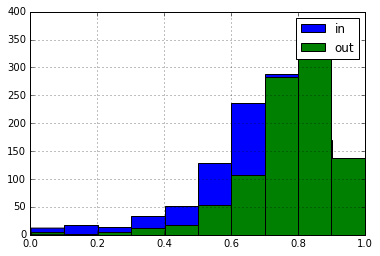

In [21]:
df['in'].hist(label='in')
df['out'].hist(label='out')
plt.legend(loc='upper right')

In [23]:
LogReg_in.coef_

array([[ 0.05897851]])

In [24]:
LogReg_out.coef_

array([[ 0.08312702]])

# all_edge_data

In [30]:
present_edges = all_edge_data['is_edge'] == 1

In [50]:

indeg_present = all_edge_data['indegree'][present_edges]
indeg_absent = all_edge_data['indegree'][~present_edges]

outdeg_present = all_edge_data['outdegree'][present_edges]
outdeg_absent = all_edge_data['outdegree'][~present_edges]

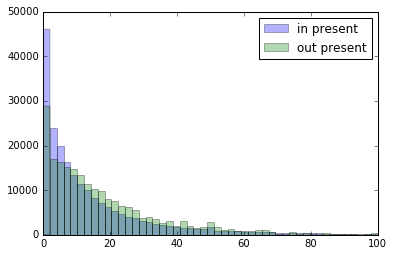

In [54]:
bins = np.linspace(0, 100, 50)

plt.hist(indeg_present,bins=bins, label='in present', alpha = .3)
#plt.hist(indeg_absent,bins=bins, label='in absent', alpha = .3)

plt.hist(outdeg_present,bins=bins, label='out present', alpha = .3)
#plt.hist(outdeg_absent,bins=bins, label='out absent', alpha = .3)


plt.legend(loc='upper right')

# make edge_df with normalization

TODO: add normalization to get edge data